# Deep AR implementation for sales prediction

In [ ]:
# for mxnet
!pip install --upgrade mxnet
# for pytorch
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

!pip install --upgrade gluoncv

!pip install gluonts

     |████████████████████████████████| 47.3 MB 1.0 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 154.6 MB 47 kB/s 
     |████████████████████████████████| 5.1 MB 34.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have tor

In [ ]:
from gluonts.dataset import common
from gluonts.model import deepar
#from gluonts.trainer import Trainer
from gluonts.mx.trainer import Trainer

import pandas as pd
from datetime import datetime

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator

import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from datetime import date, timedelta
import numpy as np

from numpy import NaN
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Predict_Future_Sales/'

items = pd.read_csv(PATH+'items.csv')
item_categories = pd.read_csv(PATH+'item_categories.csv')
shops = pd.read_csv(PATH+'shops.csv')
sales_train = pd.read_csv(PATH+'sales_train.csv')


###Data Transformation for Deep AR algorithm

In [ ]:
#sales_train = sales_train[sales_train['item_id'] <= 3000]
sales_train['date_'] = [datetime.strptime(date,"%d.%m.%Y") for date in sales_train['date']]

In [ ]:
sales_train['key'] = sales_train['date'] + sales_train['date_block_num'].astype(str) + sales_train['shop_id'].astype(str) + sales_train['item_id'].astype(str)

In [ ]:
# Aggregate to monthly level the required metrics

monthly_sales=sales_train.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [ ]:
sales_train['month_year'] = pd.to_datetime(sales_train['date_']).dt.to_period('M')

In [ ]:
monthly_sales_df = sales_train.groupby(['month_year', 'shop_id', 'item_id'])['item_cnt_day'].sum()
monthly_sales_df = monthly_sales_df.reset_index().set_index('month_year')
monthly_sales_df['shop_item_id'] = monthly_sales_df['shop_id'].astype(str) + '_'+monthly_sales_df['item_id'].astype(str)
monthly_sales_df = monthly_sales_df.drop(columns = ['shop_id','item_id']).reset_index()
monthly_sales_df = monthly_sales_df.pivot(index = 'month_year', columns = 'shop_item_id', values = 'item_cnt_day')

In [ ]:
monthly_sales_df =monthly_sales_df.transpose()

In [ ]:
monthly_sales_df2 = pd.DataFrame(columns = monthly_sales_df.index)
for i in tqdm(range(monthly_sales_df.shape[1])):
    monthly_sales_df2[i] = list(monthly_sales_df.columns)



In [ ]:
col = monthly_sales_df.iloc[0,:]
col = col.fillna(np.nan)
np.isnan(col[2])

True

In [ ]:
# This fonction converts every missing values AFTER the first non-missing value to 0
def convert_nan_to_0(col):
  col = col = col.fillna(np.nan)
  for i in range(len(col)-1):
    if np.isnan(col[i+1]) and np.isnan(col[i]):
      col[i+1] = np.nan
    elif np.isnan(col[i+1]):
      col[i+1] = 0
  return col


In [ ]:
monthly_sales_df2 = monthly_sales_df.apply(convert_nan_to_0, axis=0)
monthly_sales_df2 = monthly_sales_df2.transpose()

In [ ]:
monthly_sales_df2

shop_item_id,0_1000,0_10004,0_1001,0_10012,0_1002,0_1003,0_10033,0_10038,0_10039,0_1004,...,9_9422,9_9423,9_9424,9_9425,9_9443,9_9469,9_9532,9_9782,9_9785,9_9904
month_year,,,,,,,,,,,,,,,,,,,,,
2013-01,5.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
freq = 'd'
start_train = monthly_sales_df2.index[0].to_timestamp(freq= freq)
start_test =  monthly_sales_df2.index[-2].to_timestamp(freq= freq)
context_length = 12
prediction_length = 2

In [ ]:
monthly_sales_df2

shop_item_id,0_1000,0_10004,0_1001,0_10012,0_1002,0_1003,0_10033,0_10038,0_10039,0_1004,...,9_9422,9_9423,9_9424,9_9425,9_9443,9_9469,9_9532,9_9782,9_9785,9_9904
month_year,,,,,,,,,,,,,,,,,,,,,
2013-01,5.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
monthly_sales_df3 = monthly_sales_df2.reset_index(drop=True).T.reset_index()
ts_code = monthly_sales_df3['shop_item_id'].astype("category").cat.codes.values

In [ ]:
trainset = np.nan_to_num(monthly_sales_df3.iloc[:,1:-2].values,0)
testset = np.nan_to_num(monthly_sales_df3.iloc[:,-2:].values,0)

In [ ]:
estimator = DeepAREstimator(freq = freq,
                            context_length = context_length,
                            prediction_length = prediction_length,
                            use_feat_static_cat= True,
                            #cardinality  = [1],
                            num_layers = 2,
                            num_cells = 40,
                            cell_type = 'lstm',
                            trainer = Trainer(epochs = 5)
                            )

In [ ]:
import random
prod_to_keep = random.sample(list(range(trainset.shape[0])),3500)

In [ ]:
train_ds = ListDataset([
                        {FieldName.TARGET : target,
                         FieldName.START: start_train,
                         FieldName.FEAT_STATIC_CAT:fsc
                         }
                        for (target,fsc) in zip(trainset, ts_code.reshape(-1,1))
                        ], freq = freq)

test_ds = ListDataset([
                        {FieldName.TARGET : target,
                         FieldName.START: start_test,
                         FieldName.FEAT_STATIC_CAT:fsc
                         }
                        for (target,fsc) in zip(testset, ts_code.reshape(-1,1))
                        ], freq = freq)

In [ ]:
predictor = estimator.train(training_data= train_ds)


/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future ver

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds,
    predictor = predictor,
    num_samples = 100
)

In [ ]:
print('Obtaining time series conditioning values ...')
tss = list(tqdm(ts_it, total = len(testset)))
print('Obtaining time series predictions ...')
forecasts = list(tqdm(forecast_it, total = len(testset)))

Obtaining time series conditioning values ...


  0%|          | 0/424124 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq


Obtaining time series predictions ...


  0%|          | 0/424124 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None


In [ ]:
def plot_prob_forecast(ts_entry, forecast_entry):
  plot_length = prediction_length
  prediction_intervals = (80.0 ,95.0)
  legend = ['Observations' , 'median projection'] + [f"{k}% prediction interval" for k in prediction_intervals[::1]]

  fig, ax = plt.subplots(1,1 ,figsize = (10,7))
  ts_entry[-plot_length:].plot(ax = ax)
  forecast_entry.plot(prediction_intervals = prediction_intervals, color ='g')
  plt.grid(which ='both')
  plt.legend(legend,  loc = 'upper left')
  plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

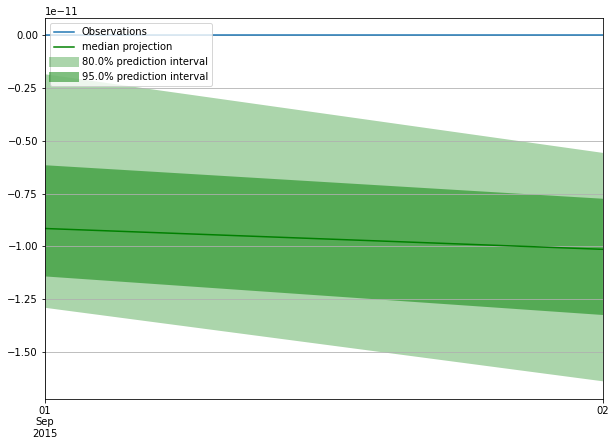

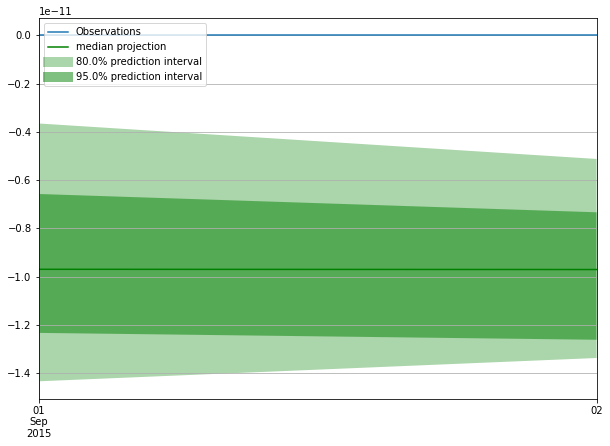

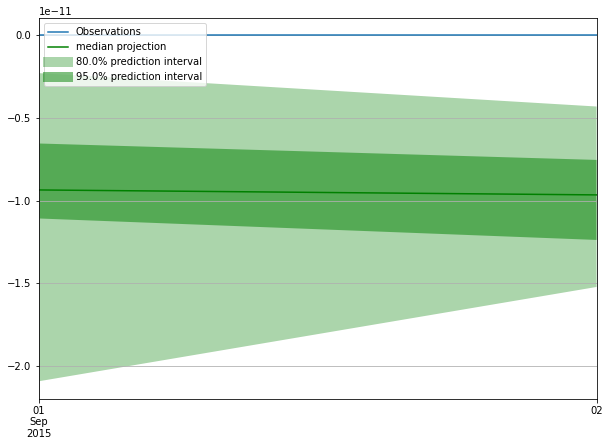

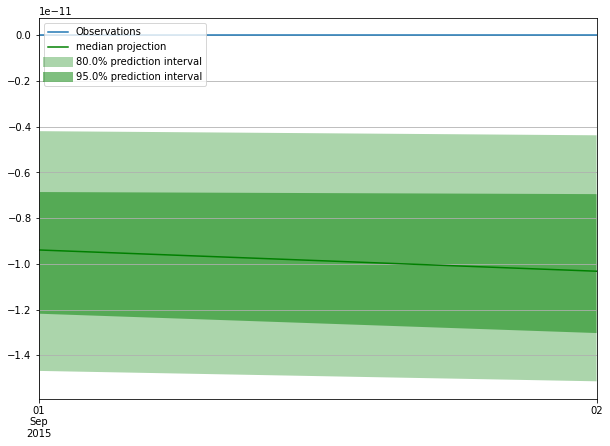

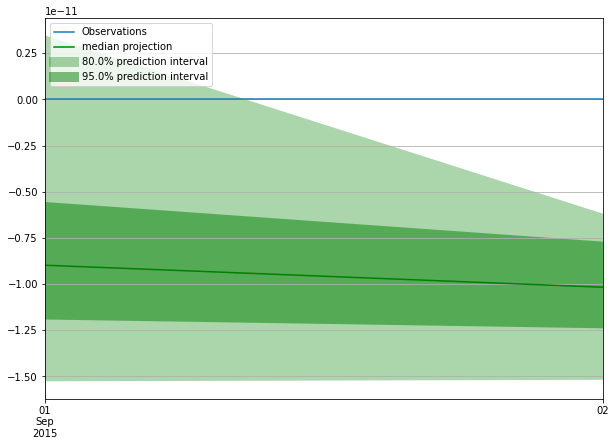

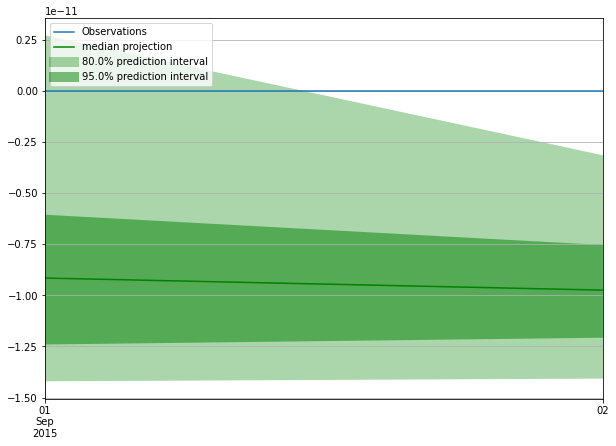

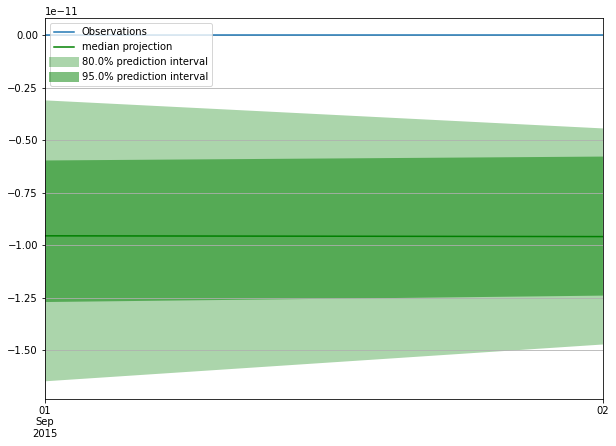

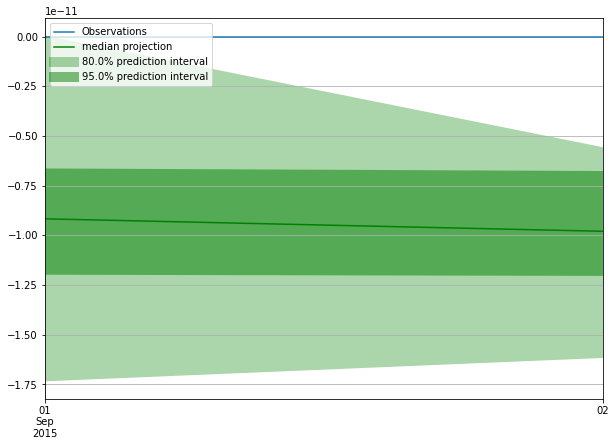

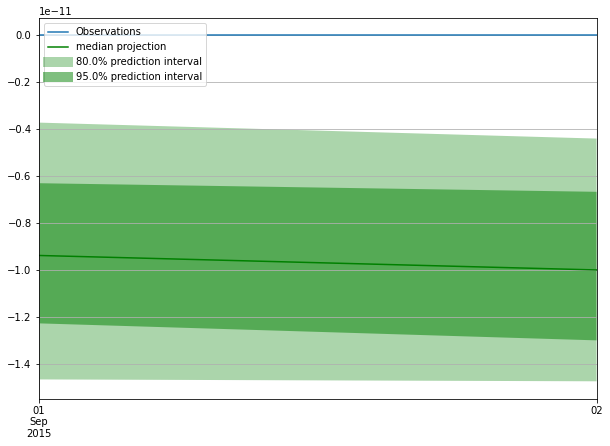

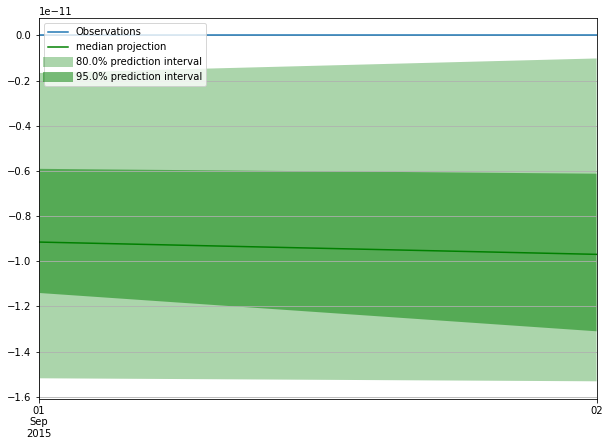

In [ ]:
for i in tqdm(range(200,210)):
  ts_entry = tss[i]
  forecast_entry = forecasts[i]
  plot_prob_forecast(ts_entry, forecast_entry)

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles = [0.1, 0.5,0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series = len(testset))

Running evaluation: 100%|██████████| 424124/424124 [00:09<00:00, 45403.09it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning

In [ ]:
agg_metrics

{'Coverage[0.1]': 4.244041836821307e-05,
 'Coverage[0.5]': 4.244041836821307e-05,
 'Coverage[0.9]': 4.244041836821307e-05,
 'MAE_Coverage': 0.49995755958163174,
 'MAPE': 1.0,
 'MASE': nan,
 'MSE': 20.156094679857777,
 'MSIS': nan,
 'ND': 1.0000000000502962,
 'NRMSE': 26.451543435237493,
 'OWA': nan,
 'QuantileLoss[0.1]': 28851.8000019641,
 'QuantileLoss[0.5]': 143971.0000076048,
 'QuantileLoss[0.9]': 259090.20000976045,
 'RMSE': 4.489553951102245,
 'abs_error': 143971.0000072412,
 'abs_target_mean': 0.16972748535805565,
 'abs_target_sum': 143971.0,
 'mean_absolute_QuantileLoss': 143971.00000644312,
 'mean_wQuantileLoss': 1.0000000000447529,
 'sMAPE': 2.0,
 'seasonal_error': nan,
 'wQuantileLoss[0.1]': 0.20040008058542416,
 'wQuantileLoss[0.5]': 1.0000000000528217,
 'wQuantileLoss[0.9]': 1.7995999194960126}

In [ ]:
for i in range(len(item_metrics)):
  print(item_metrics.index[i])
  print(item_metrics['MSE'][i])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1000
2.0618629957513597e-08
1001
2.216040867654468e-08
1002
1.068434123167648e-06
1003
2.4545023103611687e-08
1004
1.5640728912741555e-08
1005
2.501352289454512e-08
1006
0.032340715008397254
1007
2.2273483072269535e-08
1008
0.03227840700457173
1009
3.071969998810316e-08
1010
2.2006203483127344e-08
1011
2.0792743183142927e-08
1012
1.8253105750890458e-08
1013
2.196103130171973e-08
1014
2.1908634505140774e-08
1015
4.59915811241503e-08
1016
0.0647692911086544
1017
2.1065034161438234e-08
1018
1.307569824172289e-07
1019
0.06486222051805066
1020
5.305260386986417e-07
1021
2.074269163600665e-08
1022
3.0433937119537845e-08
1023
5.075123461269428e-09
1024
3.6663414287050405e-06
1025
2.8498437924070225e-06
1026
2.749499887408268e-06
1027
0.9976397483579574
1028
3.4048205106368947e-06
1029
3.056787752411178e-06
1030
2.483542375337551e-09
1031
1.2253368155260461e-08
1032
0.03228360991324148
1033
3.2501284881765323e-06
103

In [ ]:
sample_submission = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
input_df.iloc[100:150,900:]

,899,900,901,902,903,904,905,906,907,908,...,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
